# Hierarchical Agent Teams

Neste exemplo, vamos implementar a arquitetura de múltiplos agentes contendo uma hierarquia principal e uma hierarquia intermediária, tudo isso a partir de uma lógica de agentes que irão definir o funcionamento e o direcionamento dos agentes.

O exemplo será sobre um **Assistante de Pesquisa Simples**

Vamos colocar este modelo em prática, iremos seguir os seguintes passos:

1. Definir as ferramentas do agentes para acessar e gravar os arquivos;
2. Definir alguns utilitários para ajudar a criar o gráfico e os agentes;
3. Criar e definir cada equipe (pesquisa web + redação de documentos);
4. Compor tudo junto;

## Setup

Baixando os pacotes e passando as variáveis de ambiente.

In [1]:
!pip install -U langgraph langchain langchain_openai langchain_experimental

In [2]:
from google.colab import userdata
import os

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "HIERARCHICAL-AGENTS-TEAMS"

## Criando as Tools

Cada equipe será composta por um ou mais agentes, cada um com uma ou mais ferramentas


#### Tools ResearchTeam

Teremos as seguintes ferramentas:
* `scrape_webpages`
* `tavily_tool`

Serão responsáveis por realizar as buscas na internet e raspar o URL, para encontrar as informações corretas.

In [3]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool


##Buscar conteúdo na web
tavily_tool = TavilySearchResults(max_results = 5)

##Realiza a raspagem dos links
@tool
def scrape_webpages(urls: List[str]) -> str:
  "Utilize para extrair as informações de páginas web a partir do seu URL"
  loader = WebBaseLoader(urls)
  docs = loader.load()
  return "\n\n".join(
      [
          f'<Document name="{doc.metadata.get("title","")}">\n{doc.page_content}\n</Document>' for doc in docs
      ]
  )

### Tools WriterTeam

Vamos agora criar as ferramentas do time que irá escrever a redação dos documentos. Vamos utilizar as seguintes ferramentas:

* `create_outline`: Será um criador de esboços;
* `read_document`: Um leitor de documentos;
* `write_document`: Cria e salva os documentos em arquivos;
* `edit_documento`: Um editor de documentos;
* `python_repl`: Um gerador de gráficos;

In [4]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

##_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path('files')

@tool
def create_outline(
    points: Annotated[List[str], "Lista dos principais pontos ou secções"],
    file_name: Annotated[str, "O caminho do arquivo, para salvar o documento"],
    ) -> Annotated[str,"O caminho do arquivo do documento salvo"]:

  "Cria e salva um esboço"

  with (WORKING_DIRECTORY / file_name).open("w") as file:
    for i, point in enumerate(points):
        file.write(f'{i+1}. {point}\n')
  return f"O esboço foi salvo em {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "O caminho do arquivo, para salvar o documento"],
    start: Annotated[Optional[int], "O começo da linha. O padrão é 0"] = None,
    end: Annotated[Optional[int], " O final da linha. O padrão é None"] = None,
    ) -> str:

  "Le um documento especiífico"

  with (WORKING_DIRECTORY / file_name).open("r") as file:
    lines = file.readlines()
  if start is not None:
    start = 0

  return "\n".join(lines[start:end])

@tool
def write_document(
    content:
    Annotated[str, "O conteúdo de texto que será escrito no documento."],

    file_name:
    Annotated[str,"O caminho do arquivo para salvar o documento."],
    ) -> Annotated[str,"O caminho onde o documento foi salvo"]:

  "Cria e salva um documento de texto"

  with (WORKING_DIRECTORY / file_name).open("w") as file:
    file.write(content)
  return f"O documento foi salvo em {file_name}"

@tool
def edit_document(
    file_name:
    Annotated[str,"O caminho do documento que será editado."],

    inserts:
    Annotated[Dict[int,str], "Um dicionário onde a chave é o número da linha indexado em 1."],
    ) -> Annotated[str,"O caminho do documento do arquivo editado"]:

  "Edita o documento inserindo texto em específicas linhas númericas"

  with (WORKING_DIRECTORY / file_name).open("r") as file:
    lines = file.readlines()

  sorted_inserts = sorted(inserts.items())

## Aqui criamos uma validação para evitar erros nas linhas dos inserts x lines
  for line_number, text in sorted_inserts:
    if 1 <= line_number <= len(lines) + 1:
      lines.insert(line_number -1, text + "\n")
    else:
      return f"Erro: A linha de número {line_number} está fora do range"

  with (WORKING_DIRECTORY / file_name).open("w") as file:
    file.writelines(lines)

  return f"O documento foi editado e salvo em {file_name}"

repl = PythonREPL()

@tool
def python_repl(
    code:Annotated[str, "Um código em python para executar e gerar seu gráfico"]):

  """Use isto para executar um código em Python. Se você deseja visualizar o valor do resultado, você pode utilizar o comando 'print()'. Isto será visível para o usuário."""

  try:
    result = repl.run(code)
  except BaseException as e:
    return f"Falha ao executar o código {repr(e)}"
  return f"Sucesso ao executar o código: \n\'\'\ python\n{code}\n'\'\'\n Stdout: {result}"

### Funções Utilitárias

Vamos criar algumas funções que irão nos ajudar na criação do nosso Graph

* Um agente trabalhador;
* Criaremos um supervisor para os subgraphs;

Isso facilitará na continuidade do desenvolvimento do Graph.

In [5]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
##Estudar o que é o trim_messages
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")

trimmer = trim_messages(
    max_tokens = 100000,
    strategy = "last",
    token_counter = llm,
    include_system = True
)

## Função pré-construtora de agente
def agent_node(state,agent,name):
  result = agent.invoke(state)
  return {
      "messages": [HumanMessage(content=result["messages"][-1].content, name = name)]
  }

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
  "Um simples roteador de LLM"

  options = ["TERMINAR"] + members
  function_def = {
      "name":"router",
      "description":"Seleciona o próximo agente",
      "parameters":{
          "title":"routeSchema",
          "type":"object",
          "properties":{
              "next":{
                  "title":"Next",
                  "anyOf":[
                      {"enum":options},
                  ],
              },
          },
          "required":["next"],
      },
  }

  prompt = ChatPromptTemplate.from_messages(
      [
          ("system",system_prompt),
          MessagesPlaceholder(variable_name="messages"),
          (
              "system",
              "Dada a conversa acima, qual dos agentes deve seguir?"
              "Ou devemos TERMINAR? Selecione uma das opções: {options}"
          ),
      ]
  ).partial(options=str(options), team_members =", ".join(members))

  return (prompt | trimmer | llm.bind_functions([function_def], function_call = "router") | JsonOutputFunctionsParser())

## Definindos as Equipes dos Agentes

Agora vamos iniciar a construção de cada equipe de agentes, neste exemplo teremos 2 equipes.

* Equipe de Pesquisa Web;
* Equipe de Escrita;

### Equipe de Pesquisa

Dentro da equipe de pesquisa, teremos 2 agentes.

* `search_agent`;
* `researcher_agent`;

Eles serão os responsáveis por buscar as informações na internet.

In [6]:
import functools
import operator
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

class ResearchTeamState(TypedDict):
  ## A mensagem será inserida após cada membro do time finalizar
  messages: Annotated[List[BaseMessage],operator.add]
  ## A lista com os membros da equipe de pesquisa
  team_members: List[str]
  ## O roteador irá chamar uma função, que será responsável por atualizar o 'next'
  next: str

llm = ChatOpenAI(model="gpt-4o-mini")

## Estruturando o Agent de Search
search_agent = create_react_agent(llm, tools = [tavily_tool])
search_node = functools.partial(agent_node, agent = search_agent, name = "Search")


## Estruturando o Agent de Research
researcher_agent = create_react_agent(llm, tools=[scrape_webpages])
researcher_node = functools.partial(agent_node, agent=researcher_agent, name = "WebScraper")


## Criando um agente supervisor, responsável por gerenciar os agentes do time
supervisor_agent = create_team_supervisor(
    llm,
    "Você é um Supervisor encarregador de gerenciar uma conversa entre os"
    "seguintes trabalhadores: {team_members}. Dada a seguinte solicitação"
    "do usuário responda com o trabalhador para agir em seguida."
    "Cada trabalhador executará uma tarefa e responderá com seus resultado e "
    "status. Quando terminar, responda com TERMINAR.",
    ["Search", "WebScraper"]
)

<ipython-input-5-7ad6647c17a3>:59: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 0.3.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  return (prompt | trimmer | llm.bind_functions([function_def], function_call = "router") | JsonOutputFunctionsParser())


In [7]:
##Inicializando o graph
researcher_graph = StateGraph(ResearchTeamState)

##Criando os nodes
researcher_graph.add_node('Search', search_node)
researcher_graph.add_node("WebScraper", researcher_node)
researcher_graph.add_node("supervisor", supervisor_agent)

##Definindo o controle do fluxo
researcher_graph.add_edge('Search', 'supervisor')
researcher_graph.add_edge('WebScraper', 'supervisor')
researcher_graph.add_conditional_edges(
    'supervisor',
    lambda x: x['next'],
    {'Search': 'Search', 'WebScraper': 'WebScraper', 'TERMINAR': END}
)
researcher_graph.add_edge(START, 'supervisor')

## Compilando o graph
chain = researcher_graph.compile()

## Criando um separador de entrada, para depois poder se comunicar com o graph de outra hierarquia e não ter interferência entre os states de cada um
def enter_chain(message: str):
  results = {
      'messages': [HumanMessage(content=message)],
  }

  return results

research_chain = enter_chain | chain

#### Visualizando o Graph

Vamos visualizar um diagrama de mermaid com os nodes da chain.

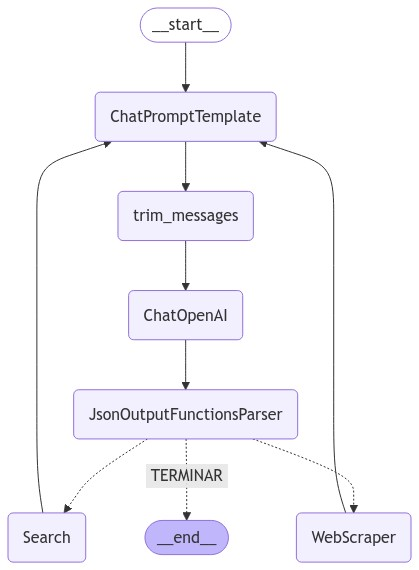

In [8]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

#### Testando

Agora vamos realizar um teste, para analisarmos exclusivamente o graph do time de pesquisa.

In [9]:
for s in research_chain.stream(
    "Quando será o próximo show da Taylor Switf?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='O próximo show da Taylor Swift será no Brasil nos seguintes dias:\n\n- **17 de novembro de 2023**: Rio de Janeiro, Estádio Nilton Santos – Engenhão\n- **18 de novembro de 2023**: Rio de Janeiro, Estádio Nilton Santos – Engenhão\n- **19 de novembro de 2023**: Rio de Janeiro, Estádio Nilton Santos – Engenhão\n\nEla também fará shows em Buenos Aires, Argentina, nos dias 10 e 11 de novembro de 2023. Se precisar de mais informações sobre ingressos ou locais, posso ajudar!', additional_kwargs={}, response_metadata={}, name='Search')]}}
---
{'supervisor': {'next': 'TERMINAR'}}
---


### Equipe Montadora de Redação

Nessa equipe os agentes serão responsáveis por escrever as redações e salva-lás nos arquivos. Para isso vão precisar ter acesso ao arquivos também. A equipe será compostas pelos seguintes agentes:

* `doc_writer_agent`
* `note_taking_agent`
* `chart_generating_agent`

In [10]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
  ## A mensagem será inserida após cada membro do time finalizar
  messages: Annotated[List[BaseMessage], operator.add]

  ## Os membros da equipe de escrita
  team_members: str
  ## O roteador irá chamar uma função, que será responsável por atualizar o 'next'
  next: str

  ##Mantém mapeado qual é o caminho do arquivo atual
  current_file: str


##Função auxiliar, responsável por vericicar se existe o repositório criado e segundo quais os arquivos dentro do repositório, ela informará os agentes quais arquivos e seus caminhos, o que auxiliará eles posteriormente.
def prelude(state):

  written_files = []

  if not WORKING_DIRECTORY.exists():
    WORKING_DIRECTORY.mkdir()

  try:
    written_files = [
        f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob('*')
    ]
  except Exception:
    pass

  if not written_files:
   return {**state, 'current_files': 'No files written'}

  return{
      **state,
      'current_files': '\nBelow are files your team has written to the directory:\n' + '\n'.join([f' - {f}' for f in written_files]),
  }

llm = ChatOpenAI(model='gpt-4o-mini')


##Vamos adicionar o prelude em todos os agentes, para auxiliar ele no caminho dos diretorios
## ----------------------------------
### Seguindo os passos:
## 1. Criar o agent
## 2. Adicionar o contexto do prelude
## 3. Criar o node

doc_writer_agent = create_react_agent(
    llm,tools=[write_document,edit_document,read_document])
context_aware_doc_writter_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writter_agent, name = 'DocWriter'
)

note_taking_agent = create_react_agent(llm, tools = [create_outline,read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent = context_aware_note_taking_agent, name = 'NoteTaker'
)

chart_generating_agent = create_react_agent(llm, tools = [read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent = context_aware_chart_generating_agent, name = 'ChartGenerator'
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "Você é um Supervisor encarregador de gerenciar uma conversa entre os"
    "seguintes trabalhadores: {team_members}. Dada a seguinte solicitação"
    "do usuário responda com o trabalhador para agir em seguida."
    "Cada trabalhador executará uma tarefa e responderá com seus resultado e "
    "status. Quando terminar, responda com TERMINAR.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [11]:
##Inicializando o Graph
authoring_graph = StateGraph(DocWritingState)

##Adicionando os nodes no Graph
authoring_graph.add_node('DocWriter', doc_writing_node)
authoring_graph.add_node('NoteTaker', note_taking_node)
authoring_graph.add_node('ChartGenerator', chart_generating_node)
authoring_graph.add_node('supervisor', doc_writing_supervisor)

##Definindo os edges normais do Graph
authoring_graph.add_edge('DocWriter', 'supervisor')
authoring_graph.add_edge('NoteTaker', 'supervisor')
authoring_graph.add_edge('ChartGenerator', 'supervisor')

##Definindo edge condicionais do Graph
authoring_graph.add_conditional_edges(
    'supervisor',
    lambda x: x['next'],
    {
        'DocWriter': 'DocWriter',
        'NoteTaker': 'NoteTaker',
        'ChartGenerator': 'ChartGenerator',
        'TERMINAR': END
    },
)

##Definindo onde o graph inicia
authoring_graph.add_edge(START,'supervisor')

##Compilando o graph
chain = authoring_graph.compile()

## Criando um separador de entrada, para depois poder se comunicar com o graph de outra hierarquia e não ter interferência entre os states de cada um
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

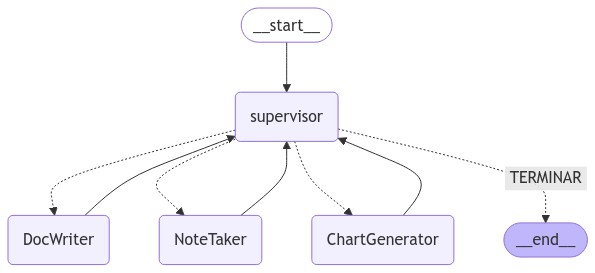

In [12]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [13]:
for s in authoring_chain.stream(
    "Write an outline for poem and then write the poem to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The poem has been written and saved to "poem.txt". Here is the poem based on the outline:\n\n---\n\nIn the quiet of the morning light,  \nA world awakens, vibrant and bright.  \nThe sun climbs high, a golden sphere,  \nWhispering hopes for all to hear.  \n\nIn shadows cast, the dreams unfold,  \nOf stories and tales yet to be told.  \nEmotions rise like tidal waves,  \nIn hearts of the bold and the brave.  \n\nThe climax peaks in fiery red,  \nAs passions flare and words are said.  \nIn twilight\'s glow, reflections glean,  \nOn what has been and what is seen.  \n\n--- \n\nFeel free to read or modify it as you wish!', additional_kwargs={}, response_metadata={}, name='NoteTaker')]}}
---
{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The poem has been successfully written and saved to "poem.txt".', additional_kwargs={}, response_metadata={}, name='DocWr

## Adicionando Camadas

Agora já criamos tanto a equipe de Pesquisa, como a equipe de Escrita, agora precisamos desenvolver 1 supervisor que gerecie essas duas equipes e defina quando cada uma delas será chamada.

In [14]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

supervisor_node = create_team_supervisor(
    llm,
    "Você é um Supervisor encarregador de gerenciar uma conversa entre os"
    "seguintes trabalhadores: {team_members}. Dada a seguinte solicitação"
    "do usuário responda com o trabalhador para agir em seguida."
    "Cada trabalhador executará uma tarefa e responderá com seus resultado e "
    "status. Quando terminar, responda com TERMINAR.",
    ["ResearchTeam","PaperWritingTeam"],
)

In [15]:
class State(TypedDict):
  messages: Annotated[List[BaseMessage], operator.add]
  next: str

def get_last_message(state:State) -> str:
  return state['messages'][-1].content

##Função responsável dar entrada no próximo graph, passando a última mensagem
def join_graph(response: dict):
  return {'messages': [response['messages'][-1]]}

##Criando os nodes
super_graph = StateGraph(State)
super_graph.add_node('ResearchTeam', get_last_message | research_chain | join_graph)
super_graph.add_node('PaperWritingTeam', get_last_message | authoring_chain | join_graph)
super_graph.add_node('supervisor', supervisor_node)

##Definindo os edges normais
super_graph.add_edge('ResearchTeam', 'supervisor')
super_graph.add_edge('PaperWritingTeam', 'supervisor')

##Definindo edge condicional
super_graph.add_conditional_edges(
    'supervisor',
    lambda x: x['next'],
    {'ResearchTeam': 'ResearchTeam',
    'PaperWritingTeam': 'PaperWritingTeam',
    'TERMINAR': END}
)

super_graph.add_edge(START, 'supervisor')
super_graph = super_graph.compile()

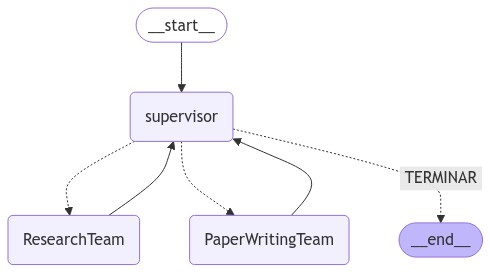

In [16]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

## Streaming do Modelo

Agora por fim vamos visualizar os resultados, para isso vamos utilizar o stream, onde poderemos ver o passo a passo de execução do Graph.

In [19]:
result = super_graph.stream(
    {"messages":
     [HumanMessage(
            content="Faça uma pesquisa de mercado, mapeando as principais transportadoras do mercado brasileiro, ao final salve o relatório e gere um gráfico das transportadoras por segmento para o usuário visualizar."
            )
      ],
     },
  {"recursion_limit": 150},
)

In [20]:
for r in result:
    print(r)
    print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='Parece que houve um problema ao tentar acessar algumas das páginas da web para coletar informações sobre as transportadoras. Mesmo assim, podemos proceder com um relatório básico com os dados que já temos.\n\n### Relatório sobre as Principais Transportadoras do Brasil\n\n**Data da Pesquisa:** Março de 2023\n\n#### Principais Transportadoras\n\n1. **Braspress**\n   - Frota: 2.990 veículos\n   - Filiais: 114\n   - Operação: Nacional\n\n2. **TNT**\n   - Frota: Mais de 2.000 caminhões próprios e 800 terceirizados\n   - Operação: Presença global, incluindo o Brasil\n\n3. **Transportadora XYZ** (exemplo fictício)\n   - Frota: 1.500 veículos\n   - Filiais: 50\n   - Operação: Nacional, com foco em logística e transporte de cargas pesadas.\n\n4. **Transportadora ABC** (exemplo fictício)\n   - Frota: 1.800 veículos\n   - Filiais: 60\n   - Operação: Nacional, atuando em diversos segmentos.\n\n#### Se

### Observações Finais

* Possivelmente um projeto deste tamanho, talvez precise de um modelo  de LLM mais potente.

* Podemos melhorar o roteamento com prompts e descrições mais especifícos e sofisticadas, atualmente as que temos são muito genéricas.

* Por mais interessante que seja, as vezes aparenta ser 'over' realizar toda essa engenharia.

* Outro ponto interessante seria na hora de salvar o relatório, definir um prompt que tenha few-shot prompts incluídos, para ajudar o modelo em uma schema padrão de formatação.